##  MACD ( Moving Average Convergence Divergence)

In [ ]:
#MACD 오실레이터 계산 및 시각화 코드 (최근 2년 기준)

요소	설명
MACD Line	단기(12) vs 장기(26) 이동평균선 차이

Signal Line	MACD의 9일 지수이동평균

MACD 오실레이터	MACD - Signal (0선 기준 교차 시 매매 판단)

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\pykrx\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


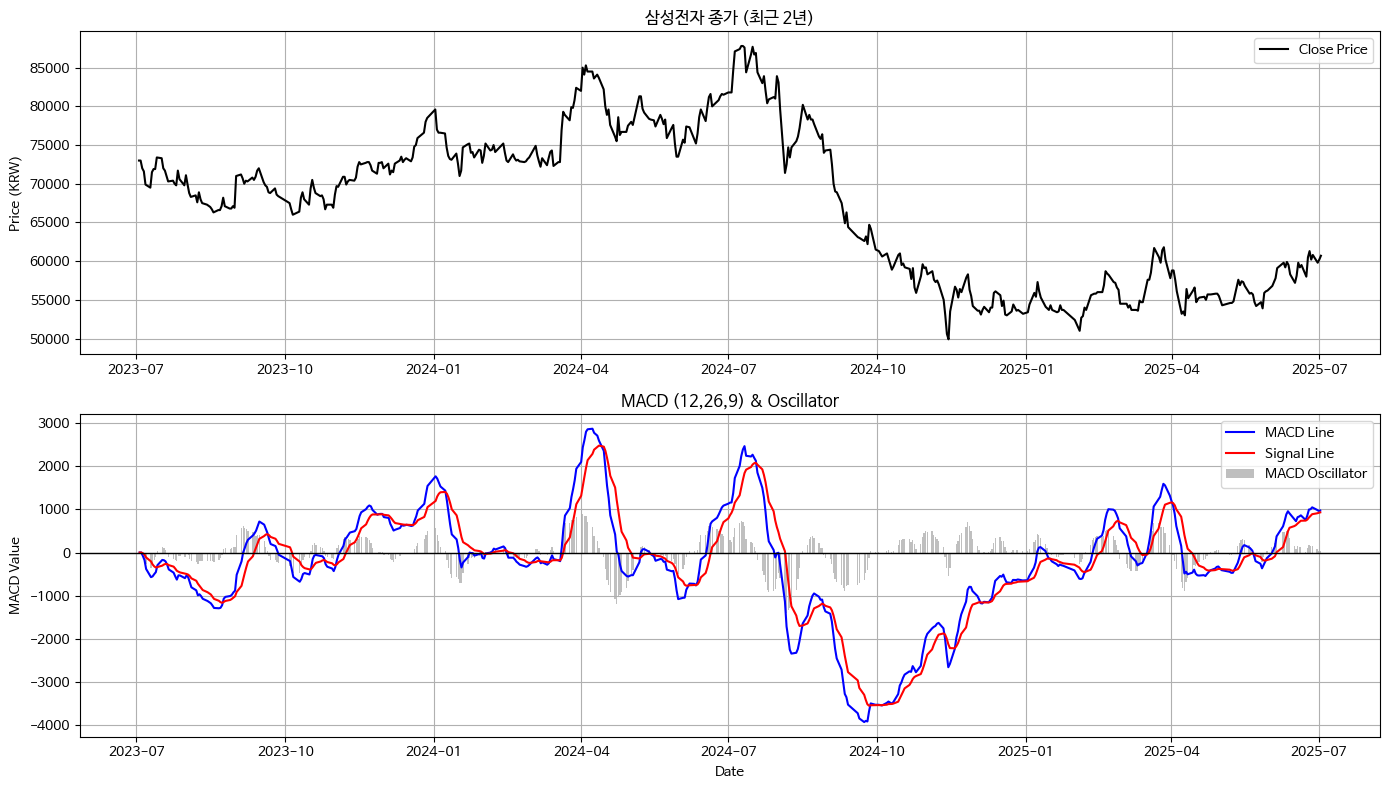

In [1]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. 날짜 설정 (최근 2년)
end_date = datetime.today().strftime('%Y%m%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y%m%d')

# 2. 삼성전자 시세 데이터 가져오기
df = stock.get_market_ohlcv_by_date(start_date, end_date, "005930")
df.index = pd.to_datetime(df.index)

# 3. MACD 계산
df['EMA12'] = df['종가'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['종가'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Oscillator'] = df['MACD'] - df['Signal']

# 4. 시각화
plt.figure(figsize=(14, 8))

# (1) 종가 차트
plt.subplot(2, 1, 1)
plt.plot(df.index, df['종가'], label='Close Price', color='black')
plt.title('삼성전자 종가 (최근 2년)')
plt.ylabel('Price (KRW)')
plt.grid(True)
plt.legend()

# (2) MACD + Signal + 오실레이터
plt.subplot(2, 1, 2)
plt.plot(df.index, df['MACD'], label='MACD Line', color='blue')
plt.plot(df.index, df['Signal'], label='Signal Line', color='red')
plt.bar(df.index, df['MACD_Oscillator'], label='MACD Oscillator', color='gray', alpha=0.5)
plt.axhline(0, color='black', linewidth=1)
plt.title('MACD (12,26,9) & Oscillator')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## MACD 기반 매매 전략 (예: 골든크로스 매수, 데드크로스 매도)

구분	조건

매수	MACD가 Signal을 하단에서 상향 돌파 (MACD_prev < Signal_prev and MACD > Signal)

매도	MACD가 Signal을 상단에서 하향 돌파 (MACD_prev > Signal_prev and MACD < Signal)

수수료	매수·매도 각각 0.3% (총 0.6%) 반영

총 거래 횟수: 22
평균 수익률: -2.32%
누적 수익률: -41.88%


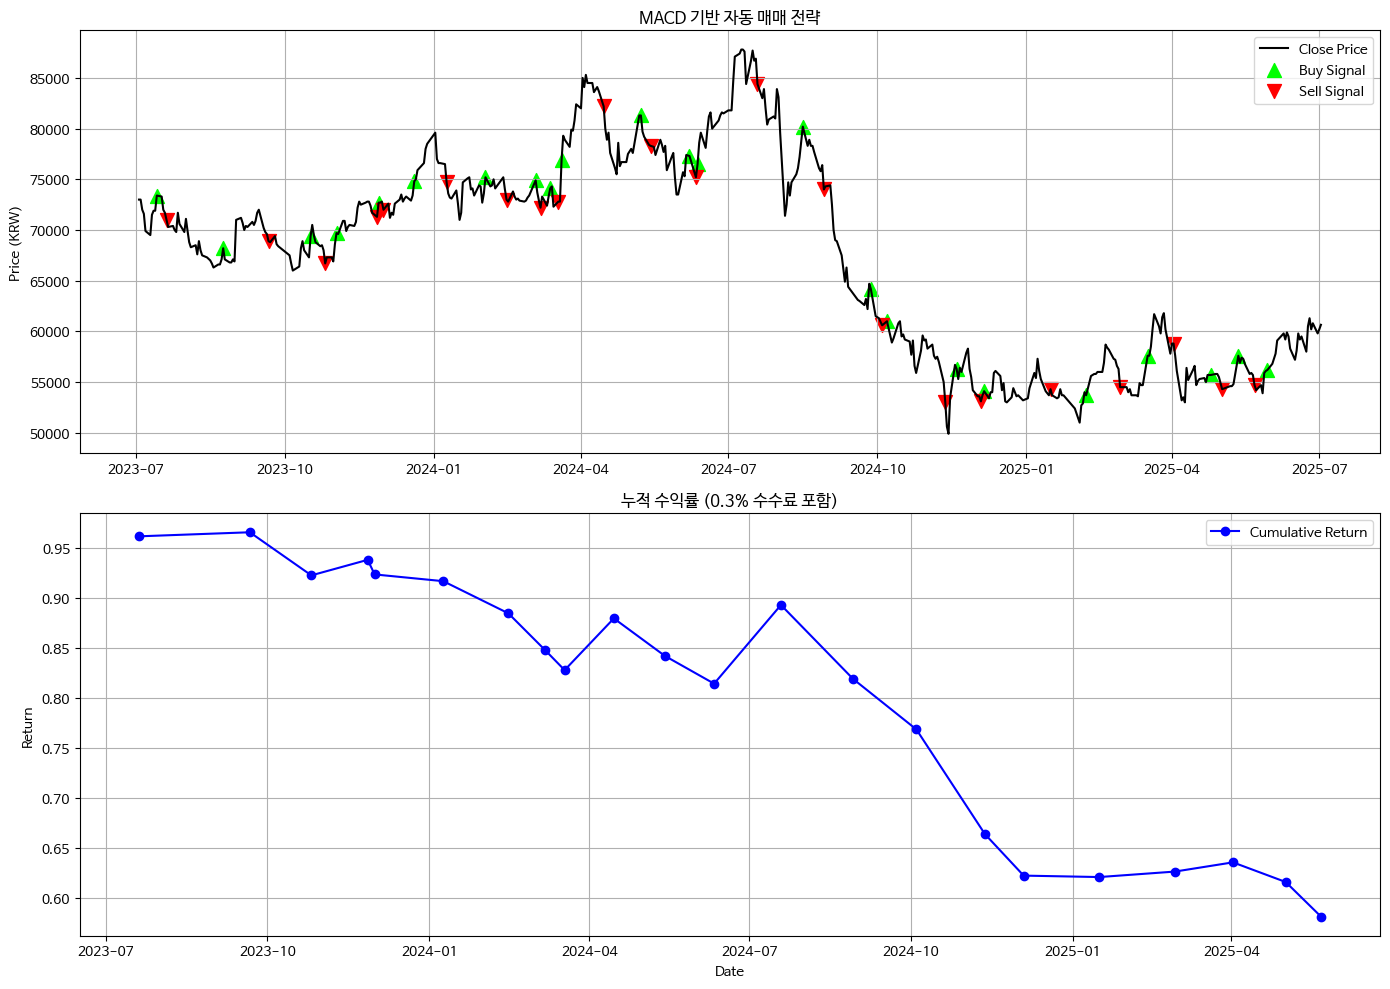

In [2]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. 데이터 수집 (삼성전자 최근 2년)
end_date = datetime.today().strftime('%Y%m%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y%m%d')
df = stock.get_market_ohlcv_by_date(start_date, end_date, "005930")
df.index = pd.to_datetime(df.index)

# 2. MACD 계산
df['EMA12'] = df['종가'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['종가'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_prev'] = df['MACD'].shift(1)
df['Signal_prev'] = df['Signal'].shift(1)

# 3. 매수/매도 조건 정의
df['Buy'] = (df['MACD_prev'] < df['Signal_prev']) & (df['MACD'] > df['Signal'])
df['Sell'] = (df['MACD_prev'] > df['Signal_prev']) & (df['MACD'] < df['Signal'])

# 4. 백테스트
fee = 0.003
trades = []
position = None

for date, row in df.iterrows():
    if position is None and row['Buy']:
        position = {
            'buy_date': date,
            'buy_price': row['종가'] * (1 + fee)
        }
    elif position is not None and row['Sell']:
        sell_price = row['종가'] * (1 - fee)
        position['sell_date'] = date
        position['sell_price'] = sell_price
        position['return'] = (sell_price - position['buy_price']) / position['buy_price']
        trades.append(position)
        position = None

results = pd.DataFrame(trades)
if not results.empty:
    results['cum_return'] = (1 + results['return']).cumprod()

# 5. 결과 출력
print("총 거래 횟수:", len(results))
if not results.empty:
    print("평균 수익률: {:.2f}%".format(results['return'].mean() * 100))
    print("누적 수익률: {:.2f}%".format((results['cum_return'].iloc[-1] - 1) * 100))

# 6. 시각화
plt.figure(figsize=(14, 10))

# (1) 종가 + 매매 시점
plt.subplot(2, 1, 1)
plt.plot(df.index, df['종가'], color='black', label='Close Price')
plt.scatter(df[df['Buy']].index, df[df['Buy']]['종가'], marker='^', color='lime', label='Buy Signal', s=100)
plt.scatter(df[df['Sell']].index, df[df['Sell']]['종가'], marker='v', color='red', label='Sell Signal', s=100)
plt.title('MACD 기반 자동 매매 전략')
plt.ylabel('Price (KRW)')
plt.grid(True)
plt.legend()

# (2) 누적 수익률
if not results.empty:
    plt.subplot(2, 1, 2)
    plt.plot(results['sell_date'], results['cum_return'], marker='o', color='blue', label='Cumulative Return')
    plt.title('누적 수익률 (0.3% 수수료 포함)')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 전략 해석 요약
# 항목	설명
# Buy Signal	MACD가 Signal을 아래에서 위로 돌파
# Sell Signal	MACD가 Signal을 위에서 아래로 돌파
# 수익률 계산	수수료 포함: 매수 시 +0.3%, 매도 시 -0.3%